# import the library

In [1]:
import re
import ftfy
import nltk
import itertools
import numpy as np
import pandas as pd
import pickle as pkl
from pathlib import Path
from nltk import PorterStemmer
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D

# Read data from folder

In [2]:
np.random.seed(1234) 

In [3]:
df = pd.read_csv('input/data.csv')

In [4]:
df.head()

,COMPLAINT DESCRIPTION,TYPE,CRIME CATEGORY,SECTIONS IN IPC
0,Many expensive things have been stolen from my...,house robbery,Robbery,Section 392 IPC
1,I would like bring to your attention the follo...,vehicle robbery,Robbery,Section 392 IPC
2,"Respected Sir/Madam,\nOn (date), while travell...",mobile robbery,Robbery,Section 392 IPC
3,"Respected Authority,im a resident of your poli...",jewellery robbery,Robbery,NaN
4,I would like bring to your attention that on (...,wallet robbery,Robbery,NaN


In [5]:
max_length = 250
nb_max_words = 100
embedding_dim = 30

# Data PreProcessing

In [6]:
df.columns

Index(['COMPLAINT DESCRIPTION ', 'TYPE', 'CRIME CATEGORY', 'SECTIONS IN IPC '], dtype='object')

In [7]:
review = df['COMPLAINT DESCRIPTION '].values
result = df['CRIME CATEGORY'].values

In [8]:
data = {'COMPLAINT DESCRIPTION ':review, 'CRIME CATEGORY':result}
df = pd.DataFrame(data)

In [9]:
df.head()

,COMPLAINT DESCRIPTION,CRIME CATEGORY
0,Many expensive things have been stolen from my...,Robbery
1,I would like bring to your attention the follo...,Robbery
2,"Respected Sir/Madam,\nOn (date), while travell...",Robbery
3,"Respected Authority,im a resident of your poli...",Robbery
4,I would like bring to your attention that on (...,Robbery


In [10]:
df['CRIME CATEGORY'].unique()

array(['Robbery', nan, 'Murder', 'Assault', 'cyber _crime',
       'Accident_case', 'Drug_crime'], dtype=object)

In [11]:
df.isna().sum()

COMPLAINT DESCRIPTION     218
CRIME CATEGORY             18
dtype: int64

In [12]:
df1 = df['CRIME CATEGORY'].value_counts()

In [13]:
df1

Drug_crime       42
Accident_case    41
Murder           40
Robbery          39
cyber _crime     39
Assault          20
Name: CRIME CATEGORY, dtype: int64

In [14]:
df.dropna(axis=0,inplace=True)

In [15]:
df1 = df['CRIME CATEGORY'].value_counts()

In [16]:
df1

Robbery          13
Murder            4
Assault           2
cyber _crime      1
Accident_case     1
Name: CRIME CATEGORY, dtype: int64

In [17]:
df.shape

(21, 2)

In [18]:
review = df['COMPLAINT DESCRIPTION '].values
result = df['CRIME CATEGORY'].values

# Each class count based on verified 

<Axes: ylabel='CRIME CATEGORY'>

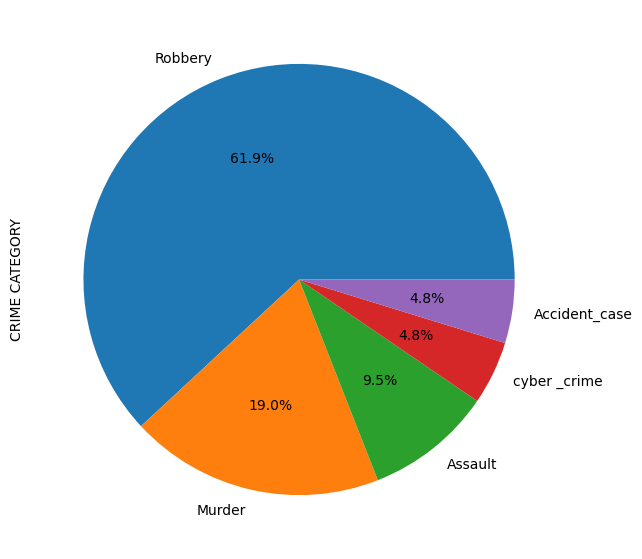

In [19]:
df1.plot.pie(y= 'Count', figsize=(7, 7),autopct='%1.1f%%')

# Data Preprocessing

In [20]:
cList = pkl.load(open('input/cword_dict.pkl','rb'))

In [21]:
print(cList)

{"ain't": 'am not', "aren't": 'are not', "can't": 'cannot', "can't've": 'cannot have', "'cause": 'because', "could've": 'could have', "couldn't": 'could not', "couldn't've": 'could not have', "didn't": 'did not', "doesn't": 'does not', "don't": 'do not', "hadn't": 'had not', "hadn't've": 'had not have', "hasn't": 'has not', "haven't": 'have not', "he'd": 'he would', "he'd've": 'he would have', "he'll": 'he will', "he'll've": 'he will have', "he's": 'he is', "how'd": 'how did', "how'd'y": 'how do you', "how'll": 'how will', "how's": 'how is', "I'd": 'I would', "I'd've": 'I would have', "I'll": 'I will', "I'll've": 'I will have', "I'm": 'I am', "I've": 'I have', "isn't": 'is not', "it'd": 'it had', "it'd've": 'it would have', "it'll": 'it will', "it'll've": 'it will have', "it's": 'it is', "let's": 'let us', "ma'am": 'madam', "mayn't": 'may not', "might've": 'might have', "mightn't": 'might not', "mightn't've": 'might not have', "must've": 'must have', "mustn't": 'must not', "mustn't've"

In [22]:
c_re = re.compile('(%s)' % '|'.join(cList.keys()))

In [23]:
c_re

re.compile(r"(ain't|aren't|can't|can't've|'cause|could've|couldn't|couldn't've|didn't|doesn't|don't|hadn't|hadn't've|hasn't|haven't|he'd|he'd've|he'll|he'll've|he's|how'd|how'd'y|how'll|how's|I'd|I'd've|I'll|I'll've|I'm|I've|isn't|it'd|it'd've|it'll|it'll've|it's|let's|ma'am|mayn't|might've|mightn't|mightn't've|must've|mustn't|mustn't've|needn't|needn't've|o'clock|oughtn't|oughtn't've|shan't|sha'n't|shan't've|she'd|she'd've|she'll|she'll've|she's|should've|shouldn't|shouldn't've|so've|so's|that'd|that'd've|that's|there'd|there'd've|there's|they'd|they'd've|they'll|they'll've|they're|they've|to've|wasn't|we'd|we'd've|we'll|we'll've|we're|we've|weren't|what'll|what'll've|what're|what's|what've|when's|when've|where'd|where's|where've|who'll|who'll've|who's|who've|why's|why've|will've|won't|won't've|would've|wouldn't|wouldn't've|y'all|y'alls|y'all'd|y'all'd've|y'all're|y'all've|you'd|you'd've|you'll|you'll've|you're|you've)",
           re.UNICODE)

In [24]:
def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group()]
    return c_re.sub(replace, text)

In [25]:
def clean_review(reviews):
    cleaned_review = []
    for review in reviews:
        review = str(review)
#         if re.match("(\w+:\/\/\S+)", review) == None and len(review) > 10:
        review = ' '.join(re.sub("(@[A-Za-z0-9]+)|(\#[A-Za-z0-9]+)|(<Emoji:.*>)|(pic\.twitter\.com\/.*)", " ", review).split())
        review = ftfy.fix_text(review)
        review = expandContractions(review)
        review = ' '.join(re.sub("([^0-9A-Za-z \t])", " ", review).split())
        stop_words = stopwords.words('english')
        word_tokens = nltk.word_tokenize(review) 
        filtered_sentence = [w for w in word_tokens if not w in stop_words]
        review = ' '.join(filtered_sentence)
        review = PorterStemmer().stem(review)
        cleaned_review.append(review)
    return cleaned_review

In [26]:
arr_review = [x for x in df['COMPLAINT DESCRIPTION ']]

In [27]:
arr_review

['Many expensive things have been stolen from my house. Gold coin of 1.5 lakhs, watch of 50,000 lakhs, mobile phones and laptops worth 1.5 lakh and 2.5 lakhs are stolen by the thieves/thief. So, I request you to please increase the security of our locality and to take some action regarding this matter.',
 'I would like bring to your attention the following facts of the case regarding the theft of the I aforementioned vehicle:\nOn 21/10/2019, I was visiting the (Name of the Specific Place and Address) for some personal/ official work. At around a.m./p.m., I had left my bicycle or bike or car in front of the building by the side of the road.\nAt around a.m./p.m, when I returned to the place where I had left my  bicycle or bike or car was missing from the place. I tried to search in the nearby areas and contacted some of my friends and family members and local residents but still could not locate my bicycle or bike or car. Hence, it is quite evident that it has been stolen by some miscrea

In [28]:
cleaned_text = clean_review(arr_review)

In [29]:
result

array(['Robbery', 'Robbery', 'Robbery', 'Robbery', 'Robbery', 'Robbery',
       'Robbery', 'Robbery', 'Robbery', 'Robbery', 'Robbery', 'Robbery',
       'Robbery', 'Murder', 'Murder', 'Murder', 'Murder', 'Assault',
       'Assault', 'cyber _crime', 'Accident_case'], dtype=object)

In [30]:
len(cleaned_text)

21

In [31]:
len(result)

21

In [32]:
data = {'Review':  cleaned_text,
        'Result': result
        }

In [33]:
df = pd.DataFrame(data, columns=['Review','Result'])

In [34]:
df.head()

,Review,Result
0,many expensive things stolen house gold coin 1...,Robbery
1,i would like bring attention following facts c...,Robbery
2,respected sir madam on date travelling i lost ...,Robbery
3,respected authority im resident police station...,Robbery
4,i would like bring attention date travelling p...,Robbery


In [35]:
df['Result'].unique()

array(['Robbery', 'Murder', 'Assault', 'cyber _crime', 'Accident_case'],
      dtype=object)

In [36]:
df.Result.value_counts()

Robbery          13
Murder            4
Assault           2
cyber _crime      1
Accident_case     1
Name: Result, dtype: int64

# Tokenizer

In [37]:
tokenizer = Tokenizer(num_words=nb_max_words)
tokenizer.fit_on_texts(cleaned_text)

In [38]:
sequences_text = tokenizer.texts_to_sequences(cleaned_text)

In [39]:
with open('model\\tokens.pkl', 'wb') as handle:
    pkl.dump(tokenizer, handle, protocol=pkl.HIGHEST_PROTOCOL)

In [40]:
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 663 unique tokens


# Add extra zero for padding

In [41]:
data = pad_sequences(sequences_text, maxlen=max_length)

print('Shape of data tensor:', data.shape)

Shape of data tensor: (21, 250)


In [42]:
data[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

# make labels as one hot encoding

In [43]:
from imblearn.over_sampling import RandomOverSampler

In [44]:
ros = RandomOverSampler(random_state=42)

In [45]:
variablex_ros, y_ros = ros.fit_resample(data, result)

In [46]:
# fit predictor and target 

print('Original dataset shape', result.shape)
print('Resample dataset shape', y_ros.shape)

Original dataset shape (21,)
Resample dataset shape (65,)


In [47]:
labels = np.asarray(pd.get_dummies(y_ros),dtype = np.int8)

In [48]:
labels[0]

array([0, 0, 0, 1, 0], dtype=int8)

In [49]:
print(variablex_ros.shape, labels.shape)

(65, 250) (65, 5)


# split data into train and test

In [50]:
X_train, X_test, Y_train, Y_test = train_test_split(variablex_ros, labels, test_size = 0.2, random_state=42)

In [51]:
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(52, 250) (52, 5) (13, 250) (13, 5)


# Build Model

In [52]:
model = Sequential()

model.add(Embedding(nb_max_words, embedding_dim, input_length=250))
model.add(Dropout(0.2))

model.add(Conv1D(250, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv1D(500, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

# model.add(Conv1D(128, 5, activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(5, activation='sigmoid'))

# Parameter tuning

In [53]:
adam = Adam(lr=0.001,
    decay=1e-06
)

ValueError: decay is deprecated in the new Keras optimizer, please check the docstring for valid arguments, or use the legacy optimizer, e.g., tf.keras.optimizers.legacy.Adam.

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=adam,
    metrics=['accuracy']
)

In [ ]:
model.summary()

# Train the model

In [ ]:
hist = model.fit(
    X_train,
    Y_train,
    validation_data=(X_test, Y_test),
    epochs=5,
    batch_size=1,
    shuffle=True
)

In [ ]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
Y_pred = model.predict(X_test)

In [ ]:
y_predict = []
for i in range(0, len(Y_pred)):
    y_predict.append(int(np.argmax(Y_pred[i])))
len(y_predict)

In [ ]:
y_true = []
for i in range(0, len(Y_test)):
    y_true.append(int(np.argmax(Y_test[i])))
len(y_true)

# test and evaluate the model

In [54]:
accuracy = accuracy_score(y_true, y_predict)
print("Accuracy: %.2f%%" % (accuracy*100))
lm_acc = accuracy*100

NameError: name 'y_true' is not defined

In [55]:
print(classification_report(y_true, y_predict))

NameError: name 'y_true' is not defined

In [56]:
def plot_confusion_matrix(cm, classes,title='Confusion matrix'):
    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap='binary')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=30)
    plt.yticks(tick_marks, classes, rotation=30)
    
    
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

In [57]:
cm = confusion_matrix(y_pred= y_predict, y_true=y_true)

NameError: name 'y_predict' is not defined

In [58]:
cm_plot_labels = ['Robbery', 'Murder', 'Assault', 'cyber _crime', 'Accident_case']

In [59]:
plot_confusion_matrix(cm,cm_plot_labels)

NameError: name 'cm' is not defined

# Store the trained model

In [60]:
model_structure = model.to_json()
f = Path("model/model_structure.json")
f.write_text(model_structure)

5518

In [61]:
model.save_weights("model/model_weights.h5")

# end